In [ ]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

In [1]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '032125'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(pheatmap)

# reading in file
weight_df = data.frame(read_excel("Input/Processed_Weight_Data_032125.xlsx"))
volume_df = data.frame(read_excel("Input/Processed_Volume_Data_032125.xlsx"))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [2]:
head(weight_df)

,HAWC_ID,Metric,Data,Study,Chemical_Class,DTXSID,Name,Value
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1098462,Weight,WS,Niu et al. 2023,Metal,Al,Al,2.6100000
2,1098462,Weight,WS,Niu et al. 2023,Metal,Ca,Ca,1.0100000
3,1098462,Weight,WS,Niu et al. 2023,Metal,Cr,Cr,0.1466667
4,1098462,Weight,WS,Niu et al. 2023,Metal,Cu,Cu,0.3500000
5,1098462,Weight,WS,Niu et al. 2023,Metal,Fe,Fe,0.9933333
6,1098462,Weight,WS,Niu et al. 2023,Metal,Mn,Mn,0.2700000


This analysis will use PCA to explore if chemical and metal concentrations of wildfire and woodsmoke samples are similar using PCA.

# Principal Component Analysis (PCA)

In [3]:
# casting wide
wider_metal_weight_df = weight_df %>%
    #filter(Chemical_Class == 'PAH') %>%
    # creating sample ids
    unite("SampleID", c(colnames(weight_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_metal_weight_df)

,HAWC_ID,Metric,Data,Study,Chemical_Class,Al,Ca,Cr,Cu,Fe,Mn,Ni,Zn
,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1098462_WS_Metal,1098462,Weight,WS,Niu et al. 2023,Metal,2.610,1.010,0.1466667,0.3500,9.933333e-01,0.2700,0.0400,2.076667
267105_WS_Metal,267105,Weight,WS,Danielsen et al. 2011,Metal,2049.469,25205.536,21.3500000,50.0000,1.548000e+03,0.0000,12.5000,890.000000
271571_WS_Metal,271571,Weight,WS,Dilger et al. 2016,Metal,19887.702,44660.640,3.4000000,4.1000,1.149174e+05,2138.0000,0.5000,4178.800000
271638_WS_Metal,271638,Weight,WS,Jalava et al. 2012,Metal,20076.879,2102.000,6497.0842750,522.0426,3.150312e+04,422.2857,405.6882,5202.857143
271769_WS_Metal,271769,Weight,WS,Uski et al. 2012,Metal,20076.879,2130.571,6497.0842750,522.0426,3.150312e+04,422.2857,405.6882,5203.142857
279220_WS_Metal,279220,Weight,WS,Kasurinen et al. 2017,Metal,4797.489,1930.000,105.0000000,278.5000,9.466667e+02,276.6667,148.5000,4375.000000


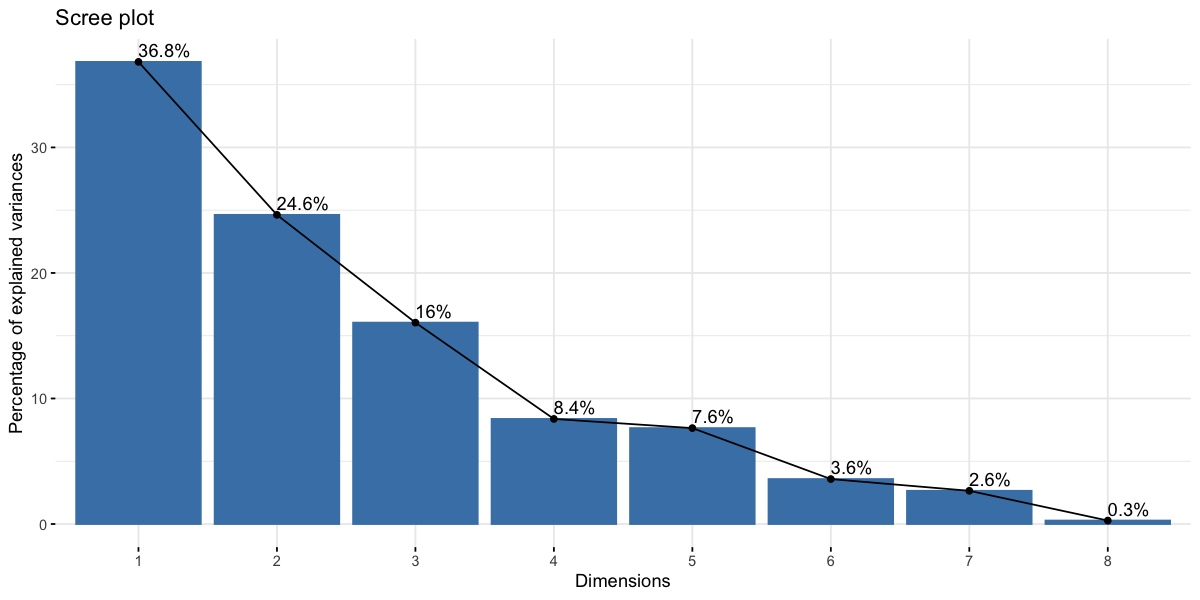

In [30]:
# running pca 
metal_weight_pca = prcomp(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], center = TRUE, scale = TRUE)
#cytokine_pca = prcomp(wider_cytokine_df[,7:11], center = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(metal_weight_pca, addlabels = TRUE)
#fviz_eig(cytokine_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [32]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
metal_weight_outliers = outlier_detection(metal_weight_pca)  
#cytokine_outliers = outlier_detection(cytokine_pca)  

In [33]:
# getting length
length(metal_weight_outliers)
#length(cytokine_outliers)

[1] 0

There were no outliers.

In [34]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data??
metal_weight_pca_df = data.frame(metal_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 
# cytokine_pca_df = data.frame(cytokine_pca$x[,1:2]) %>%
#                rownames_to_column(var = "Name_Sample_ID") 

more_data_df = #full_join(
    wider_metal_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")#), 
                                # wider_metal_weight_df[,1:5] %>% 
                                #     rename(Biomarker_Name = Cytokine, Concentration = Condensate_Conc) %>%
                                #     mutate(Time_Point = 24) %>%
                                #     rownames_to_column(var = "Name_Sample_ID")) 

full_eigenvector_df = inner_join(metal_weight_pca_df,#rbind(metal_weight_pca_df, #cytokine_pca_df), 
                                             more_data_df)#)

head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Metric,Data,Study,Chemical_Class
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1098462_WS_Metal,-1.3878617,0.32646032,1098462,Weight,WS,Niu et al. 2023,Metal
2,267105_WS_Metal,-1.2487052,0.19354360,267105,Weight,WS,Danielsen et al. 2011,Metal
3,271571_WS_Metal,2.1713859,-0.36688567,271571,Weight,WS,Dilger et al. 2016,Metal
4,271638_WS_Metal,0.6117047,0.16163903,271638,Weight,WS,Jalava et al. 2012,Metal
5,271769_WS_Metal,0.6116914,0.16153354,271769,Weight,WS,Uski et al. 2012,Metal
6,279220_WS_Metal,-0.7638398,0.07186322,279220,Weight,WS,Kasurinen et al. 2017,Metal


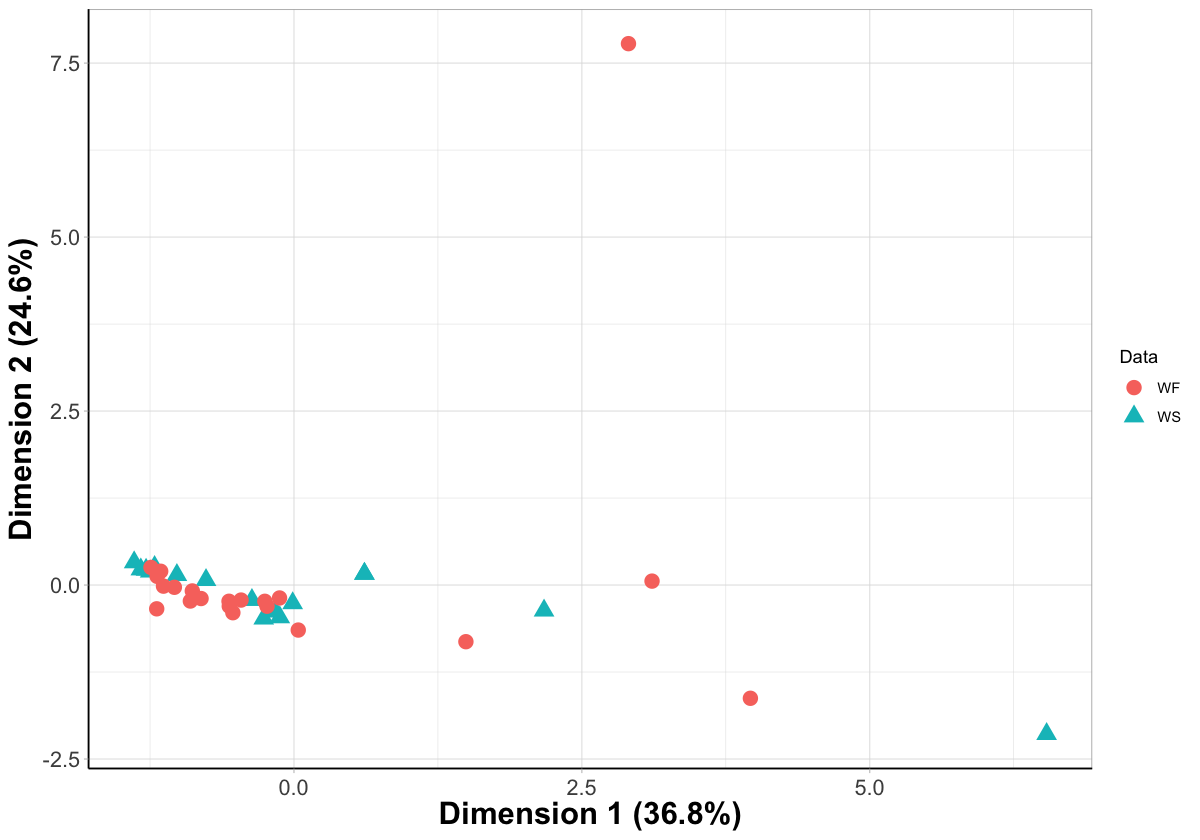

In [36]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
ggplot(data = full_eigenvector_df, 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4) + 
  #geom_text_repel(aes(label = SampleID), size = 5) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        #legend.position = 'none',
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Dimension 1 (36.8%)', y = 'Dimension 2 (24.6%)') #+ #changing axis labels 

  # scale_color_manual(values = c('#cb181d','#fb6a4a', # cardboard flaming
  #                            "#b56800", "#f09900", # cardboard smoldering
  #                            "#4d4d4d", "#808080", # controls
  #                             '#0000c1','#7f52ff', # cardboard flaming
  #                            "#005200", "#3aa22b")) # cardboard smoldering  

In [4]:
bpca = pca(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], method = 'bpca', nPcs = 30)
bpca_scores <- data.frame(bpca@scores) 

Warning message in pca(wider_metal_weight_df[, c(6:ncol(wider_metal_weight_df))], :
“more components than matrix columns requested”


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


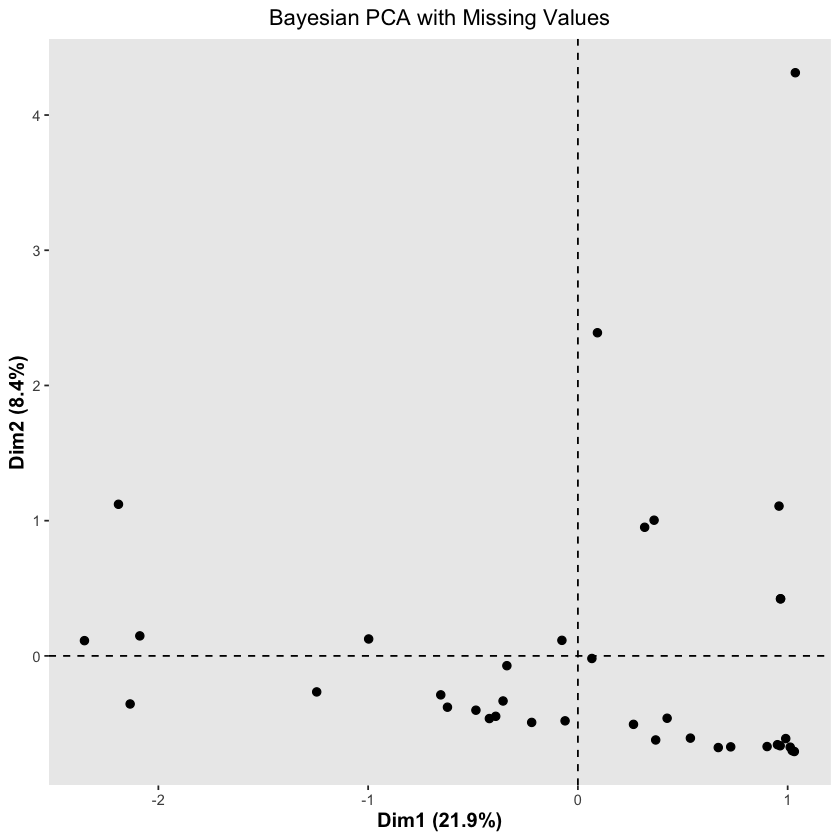

In [5]:
# Determine if there are any outliers > 6 SD from the mean
bpca_outliers <- apply(bpca_scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)

# Get percentage contribution to each axis
bpca_loadings <- data.frame(bpca@R2)

# Make plot for supplement
bpca_plot <- ggplot(bpca_scores, aes(x = PC1, y = PC2)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
  geom_point(size = 2) +
  labs(x = "Dim1 (21.9%)", y = "Dim2 (8.4%)", title = "Bayesian PCA with Missing Values") +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.title = element_text(face = "bold", size = rel(1.1)),
        plot.title = element_text(hjust = 0.5))

bpca_plot